In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.stats as stat
#from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

In [2]:
"""Synthetic data generation--- Final data will be availabe in X_train and Y_train"""
X_plus = [0,0,0,0]
X_minus = [0,0,0,0]
Y_plus = [0,0,0,0]
Y_minus = [0,0,0,0]
size = 150
for i in range(4):
    X_plus[i] = np.random.multivariate_normal(np.array([0.5,0.5]), np.array([[1,0],[0,1]]), size//2)   
    X_minus[i] = np.random.multivariate_normal(np.array([-0.5,-0.5]), np.array([[1,0],[0,1]]), size//2)
    Y_plus[i] = np.full((size//2),1)
    Y_minus[i] = np.full((size//2),0) 

X_train = [0,0,0,0]
Y_train = [0,0,0,0]
for i in range(4):
    X_train[i] = np.concatenate((X_plus[i],X_minus[i]),axis = 0)
    Y_train[i] = np.concatenate((Y_plus[i],Y_minus[i]),axis =0)
    
#Finally four datasets are created 
#X_train[i],Y_train[i]---- i varies from 1 to 4
#These represent the data before distortion

In [3]:
print(X_train[0].shape)
print(Y_train[0].shape)

(150, 2)
(150,)


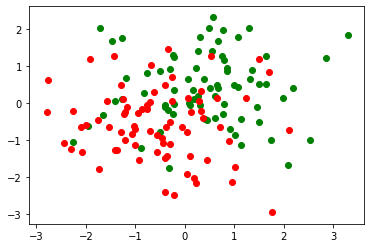

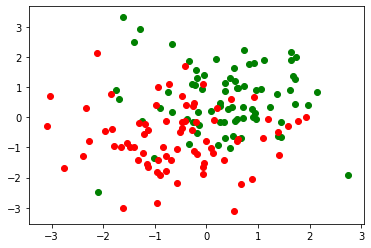

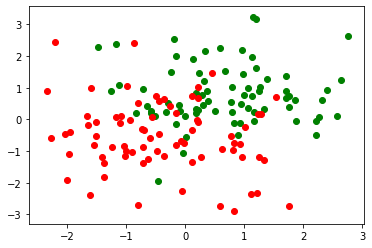

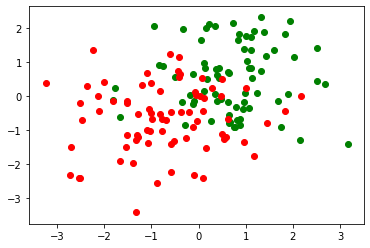

In [4]:
"""Plotting synthetic data generated"""
for i in range(4):
    X_plus_plot = X_plus[i].T
    X_minus_plot = X_minus[i].T
    plt.scatter(X_plus_plot[0],X_plus_plot[1],color = 'g')
    plt.scatter(X_minus_plot[0],X_minus_plot[1],color = 'r')
    plt.show()
    #X_plus_plot.shape
    


In [5]:
def sample_mean(A,length):
    """Function that returns sample mean of the given data"""
    return (np.sum(A,axis=0))/length

def sample_covariance(A, length, mu):
    """Function that returns sample covariance of the given data"""
    cov = np.array([[0,0],[0,0]])
    for x in A:
        y = np.array([x-mu])
        cov = cov + np.matmul(np.transpose(y),y)
        #print(cov)
    cov = cov/length
    return cov
def calc_posterior(x,mu_plus,cov_plus,mu_minus,cov_minus,prior):
    """ Function that calculates P(Y = +1|X) by using bayes formula"""
    plus_prob = stat.multivariate_normal.pdf(x,mu_plus,cov_plus)
    minus_prob = stat.multivariate_normal.pdf(x,mu_minus,cov_minus)
    val = (prior*plus_prob)/((prior*plus_prob)+((1-prior)*minus_prob))
    return val

In [6]:
def calculate_eta(X_train,Y_train):
    '''Function that finds P(1|X=x) for all training samples, so that later we can apply distortion later'''
    X_plus = [0,0,0,0]
    X_minus = [0,0,0,0]
    mu_hat_plus = [0,0,0,0]
    mu_hat_minus = [0,0,0,0]
    cov_hat_plus = [0,0,0,0]
    cov_hat_minus = [0,0,0,0]
    prior = [0,0,0,0]
    eta = [0,0,0,0]   # this list contains eta of all the data sets
    Y_pred = [0,0,0,0]
    for p in range(4):
        X_plus_temp = []
        X_minus_temp = []

        for i in range(int(X_train[p].shape[0])):
            if(Y_train[p][i] == 1):
                X_plus_temp.append(X_train[p][i])
            else:
                X_minus_temp.append(X_train[p][i])
        X_plus[p] = np.array(X_plus_temp)
        X_minus[p] = np.array(X_minus_temp)

        mu_hat_plus[p] = sample_mean(X_plus[p],X_plus[p].shape[0])
        mu_hat_minus[p] = sample_mean(X_minus[p],X_minus[p].shape[0])
        cov_hat_plus[p] = sample_covariance(X_plus[p],X_plus[p].shape[0],mu_hat_plus[p])
        cov_hat_minus[p] = sample_covariance(X_minus[p],X_minus[p].shape[0],mu_hat_minus[p] )

        len_plus = X_plus[p].shape[0]
        len_minus= X_minus[p].shape[0]
        prior[p] = len_plus /(len_plus + len_minus)
        eta_temp = []
        for i in range(X_train[p].shape[0]):
            eta_temp.append(calc_posterior(X_train[p][i],mu_hat_plus[p],cov_hat_plus[p],mu_hat_minus[p],cov_hat_minus[p],prior[p]))
        eta[p] = np.array(eta_temp)
        Y_pred_temp = []
        for i in range(X_train[p].shape[0]):
            Y_pred_temp.append(np.sign(eta[p][i]-0.5))
        Y_pred[p] = np.array(Y_pred_temp)
        #print(accuracy_score(Y_train[p],Y_pred[p]))
    return eta

In [7]:

def distort_eta(eta_original):
    eta_list = []
    eta_list.append(eta_original[0])       #correct labeller ---> no distortion caused
    eta_list.append(0.7*eta_original[1] + 0.1)  # linear distortion
    eta_list.append(0.5*stat.beta.cdf(eta_original[2],100,200) + 0.5*stat.beta.cdf(eta_original[2],200,100))   #aggressive labeller
    eta_list.append(0.5*stat.beta.cdf(eta_original[3],0.1,0.2) + 0.5*stat.beta.cdf(eta_original[3],0.2,0.1))  # distortion based on alpha = 0.5 and beta = 0.5
    return eta_list


def calculate_distorted_labels(eta_list):
    Y_distort = []
    for i in range(4):
        lis = []
        for p in eta_list[i]:
            res = (np.random.binomial(1,p,1) )
            if(res == 0): res = 0
            lis.append(res)
        lis = np.array(lis)
        Y_distort.append(lis)
    return Y_distort

In [8]:

eta_original = calculate_eta(X_train,Y_train)
eta_list = distort_eta(eta_original)
print(eta_original[0].size)
print(eta_list[0].size)
X_test_d = [0,0,0,0]
Y_test_d = [0,0,0,0]
X_train_d = [0,0,0,0]
Y_train_d = [0,0,0,0]
Y_test_d = [0,0,0,0]
Y_d = calculate_distorted_labels(eta_list)
trainsize = 100
testsize = 50
for i in range(4):
    X_train_d[i] = np.concatenate((X_train[i][:trainsize//2], X_train[i][trainsize//2+testsize//2:trainsize+testsize//2]),axis = 0)
    X_test_d[i] = np.concatenate((X_train[i][trainsize//2:trainsize//2+testsize//2], X_train[i][trainsize+testsize//2:trainsize+testsize]),axis = 0)
    Y_train_d[i] = np.concatenate((Y_d[i][:trainsize//2], Y_d[i][trainsize//2+testsize//2:trainsize+testsize//2]),axis = 0)
    Y_test_d[i] = np.concatenate((Y_d[i][trainsize//2:trainsize//2+testsize//2], Y_d[i][trainsize+testsize//2:trainsize+testsize]),axis = 0)
    print(X_train_d[i].shape, Y_train_d[i].shape,X_test_d[i].shape, Y_test_d[i].shape)
    
#Final distorted data is availabe as follows
#X_train_d[i],Y_train_d[i],X_test_d[i], Y_test_d[i]---- i varies from 1 to 4


150
150
(100, 2) (100,) (50, 2) (50,)
(100, 2) (100,) (50, 2) (50,)
(100, 2) (100,) (50, 2) (50,)
(100, 2) (100,) (50, 2) (50,)


In [9]:
X_train_distort_plus = []
X_train_distort_minus = []
X_test_distort_plus = []
X_test_distort_minus = []
for i in range(4):
    lisplus = []
    lisminus = []
    j = 0
    for y in Y_train_d[i]:
        if(y == 1):
            lisplus.append(X_train_d[i][j])
        else:
            lisminus.append(X_train_d[i][j])
        j = j + 1
    lisplus = np.array(lisplus)
    lisminus = np.array(lisminus)
    X_train_distort_plus.append(lisplus)
    X_train_distort_minus.append(lisminus)
''''for i in range(4):
    lisplus = []
    lisminus = []
    j = 0
    for y in Y_test_d[i]:
        if(y == 1):
            lisplus.append(X_test_d[i][j])
        else:
            lisminus.append(X_test_d[i][j])
        j = j + 1
    lisplus = np.array(lisplus)
    lisminus = np.array(lisminus)
    X_test_distort_plus.append(lisplus)
    X_test_distort_minus.append(lisminus)'''
    


   


"'for i in range(4):\n    lisplus = []\n    lisminus = []\n    j = 0\n    for y in Y_test_d[i]:\n        if(y == 1):\n            lisplus.append(X_test_d[i][j])\n        else:\n            lisminus.append(X_test_d[i][j])\n        j = j + 1\n    lisplus = np.array(lisplus)\n    lisminus = np.array(lisminus)\n    X_test_distort_plus.append(lisplus)\n    X_test_distort_minus.append(lisminus)"

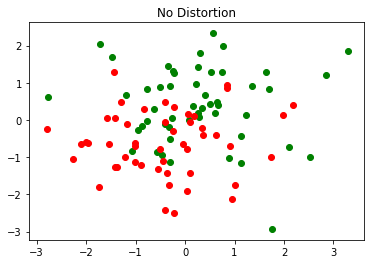

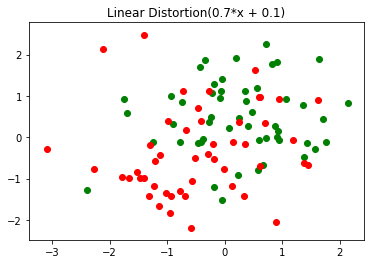

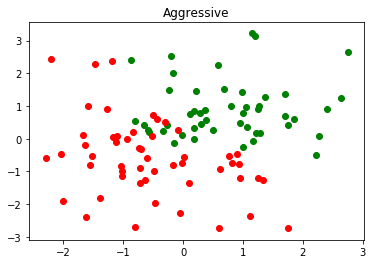

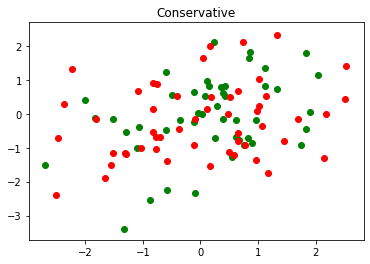

In [10]:
titles = ['No Distortion', 'Linear Distortion(0.7*x + 0.1)', 'Aggressive', 'Conservative']
for i in range(4):
    plt.title(titles[i])
    plt.scatter(X_train_distort_plus[i].T[0],X_train_distort_plus[i].T[1],color = 'g')
    plt.scatter(X_train_distort_minus[i].T[0],X_train_distort_minus[i].T[1],color = 'r')
    plt.show()
     #plt.scatter(X_test_distort_plus[i].T[0],X_test_distort_plus[i].T[1],color = 'g')
    #plt.scatter(X_test_distort_minus[i].T[0],X_test_distort_minus[i].T[1],color = 'r')
    #plt.show()

In [25]:
def accuracy_score(Y, Y_pred):
    loss = 0.0
    for i in range(Y.shape[0]):
        #print((Y[i] - Y_pred[i])**2)
        loss = loss + ((Y[i] - Y_pred[i])**2)
        
        
    #print(Y.shape[0])
    return loss/(Y.shape[0])

In [26]:
#Baseline-1 -- separate Logistic Regression for all labellers
clf_list = []
accuracy_list = []
for i in range(4):
    Y_train_d[i] =Y_train_d[i].astype('int')
    Y_test_d[i] =Y_test_d[i].astype('int')
    clf = LogisticRegression(solver='lbfgs').fit(X_train_d[i], Y_train_d[i])  #training 
    Y_pred = clf.predict_proba(X_test_d[i])[:,1]    # predicting eta(x) = P(1|x) for training samples
    #print(Y_pred)
    #print(Y_test_d[i])
    #print(Y_pred)
    accuracy_list.append(accuracy_score(Y_test_d[i],Y_pred))   # calculating accuracy
accuracy_list
#Y_test_distort[0].shape

[0.11625092795760698,
 0.1629665592950158,
 0.058101723141762145,
 0.24154036766650624]

In [27]:
#Separate Slisotron(Training Phase)
T = 100  # no. of iterations
u = [0,0,0,0]   # distortion applied by each annotator
w = []          #weight vector for each annotator
for i in range(4):
    w.append(np.array([1,0]))   # Initialisation of w
for i in range(4):
    for t in range(T):
        temp = []
        for x in X_train_d[i]:
            temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w[i]),x)))))  #(sigma(w_i^T(x)))
        temp = np.array(temp)
        u[i] = IsotonicRegression(out_of_bounds = 'clip').fit(temp,Y_train_d[i]) #updating u(Isotonic Regression)
        iso_predict = u[i].predict(temp) #(u_i(sigma(w_i^T(x)))
        sum1 = 0
        for j in range(len(X_train_d[i])):
            sum1 = sum1 + (Y_train_d[i][j] - iso_predict[j])*(X_train_d[i][j])
        sum1 = sum1/len(X_train_d[i])
        w[i] = w[i] + sum1  #updating w
    #print(w[i])
    

In [28]:
#Separate Slisotron(Testing Phase)
sl_accuracy_list = [0,0,0,0]
Y_pred_sl = [0,0,0,0]
for i in range(4):
    pred_class = []
    temp = []
    for x in X_test_d[i]:
        temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w[i]),x)))))     #(sigma(w_i^T(x)))
    temp = np.array(temp)
    pred_prob = u[i].predict(temp)           #(u_i(sigma(w_i^T(x)))
    for j in range(len(X_test_d[i])):
        if(pred_prob[i] >=0.5):
            pred_class.append(1)
        else:
            pred_class.append(0)
    pred_class = np.array(pred_class)
    Y_pred_sl[i] = pred_class
    sl_accuracy_list[i] = (accuracy_score(Y_test_d[i],np.array(pred_prob))) #loss calculation
    
sl_accuracy_list
            
        

[0.11446954276163787,
 0.1654308914027581,
 0.06059365912074937,
 0.2484558283766263]